In [100]:
import torch
import torch.nn as nn
import numpy as np

import torch
import torch.backends.cudnn as cudnn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR100
import torch.nn.functional as F
import matplotlib.pyplot as plt


class PadPrompter(nn.Module):
    def __init__(self):
        super(PadPrompter, self).__init__()
        pad_size = 5
        image_size = 84

        self.base_size = image_size - pad_size*2
        self.pad_up = nn.Parameter(torch.randn([1, 3, pad_size, image_size]))
        self.pad_down = nn.Parameter(torch.randn([1, 3, pad_size, image_size]))
        self.pad_left = nn.Parameter(torch.randn([1, 3, image_size - pad_size*2, pad_size]))
        self.pad_right = nn.Parameter(torch.randn([1, 3, image_size - pad_size*2, pad_size]))

    def forward(self, x):
        base = torch.zeros(1, 3, self.base_size, self.base_size)
        prompt = torch.cat([self.pad_left, base, self.pad_right], dim=3)
        prompt = torch.cat([self.pad_up, prompt, self.pad_down], dim=2)
        prompt = torch.cat(x.size(0) * [prompt])

        return x + prompt

def refine_classname(class_names):
    for i, class_name in enumerate(class_names):
        class_names[i] = class_name.lower().replace('_', ' ').replace('-', ' ')
    return class_names


def get_inner_loop_parameter_dict(params):

    param_dict = dict()

    for name, param in params:
        if param.requires_grad:
            if "norm_layer" not in name:
                param_dict[name] = param

    return param_dict

In [101]:
prompt = PadPrompter()

preprocess = transforms.Compose([
    transforms.Resize(84),
    transforms.ToTensor()
])

train_dataset = CIFAR100("./data", transform=preprocess,
                          download=True, train=True)

val_dataset = CIFAR100("./data", transform=preprocess,
                        download=True, train=False)

train_loader = DataLoader(train_dataset,
                          batch_size=32, pin_memory=True,
                          num_workers=16, shuffle=True)

class_names = train_dataset.classes
class_names = refine_classname(class_names)
indices = list(range(len(class_names)))

Files already downloaded and verified
Files already downloaded and verified


In [102]:
images, target = next(iter(train_loader))
prompted_images = prompt(images)

names_weights_copy = get_inner_loop_parameter_dict(prompt.named_parameters())

print(names_weights_copy.keys())
#print(names_weights_copy.values())

dict_keys(['pad_up', 'pad_down', 'pad_left', 'pad_right'])


In [103]:
loss = torch.tensor(1.9680).requires_grad_()

grads = torch.autograd.grad(loss, names_weights_copy.values(),create_graph=True, allow_unused=True)

grads

(None, None, None, None)

In [104]:
torch.manual_seed(42)
X = torch.rand(25, 3, 84, 84, requires_grad=False)
y = torch.randint(0, 5, (25,), dtype=torch.long)


# CNN 모델 정의
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(16 * 84 * 84, 5)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

    
model = CNN()        

criterion = nn.CrossEntropyLoss()

prompted_images = prompt.forward(X)
outputs = model.forward(prompted_images)
loss= F.cross_entropy(outputs, y)


names_prompt_weights_copy = get_inner_loop_parameter_dict(prompt.named_parameters())
names_weights_copy = get_inner_loop_parameter_dict(model.named_parameters())

grads = torch.autograd.grad(loss, names_prompt_weights_copy.values(),create_graph=True, allow_unused=True)
grads

(tensor([[[[-1.5524e-04, -7.1356e-05,  2.0811e-04,  ..., -5.7635e-05,
            -2.9500e-04,  3.8750e-05],
           [ 2.0983e-04, -3.2249e-05,  3.1342e-05,  ..., -1.4362e-04,
             3.0468e-04, -1.8460e-04],
           [ 2.6205e-04,  3.0193e-04, -7.8872e-05,  ..., -1.3132e-04,
            -1.6996e-04,  3.4394e-04],
           [ 1.2468e-04, -2.4871e-04, -2.8939e-04,  ...,  8.4199e-05,
             1.4529e-04, -7.3534e-05],
           [-1.9607e-04, -2.8071e-04,  4.3174e-05,  ..., -1.6229e-04,
            -1.2035e-05,  2.7256e-04]],
 
          [[-1.2010e-04, -3.1330e-04,  6.6958e-05,  ...,  1.5999e-04,
            -1.5277e-06, -6.1638e-05],
           [ 2.0500e-04, -6.8306e-05,  1.5756e-04,  ..., -2.0979e-04,
             2.0149e-04,  9.3845e-05],
           [ 5.8426e-05,  3.2009e-04,  2.0716e-04,  ...,  2.1147e-05,
             4.9094e-05, -1.4855e-04],
           [ 4.3769e-05, -1.7694e-05,  2.4613e-04,  ...,  2.4169e-04,
            -7.2999e-05,  1.3598e-04],
           [ 1.6

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


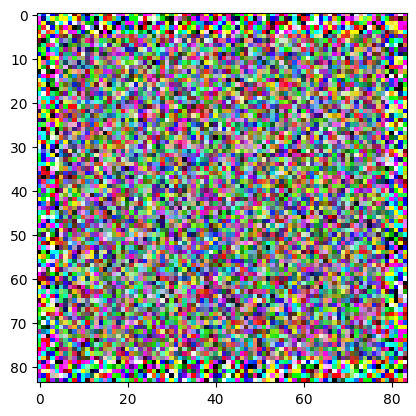

In [105]:
numpy_data = prompted_images[0].detach().numpy()

plt.imshow(numpy_data.T, cmap="gray")
plt.show()